In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import neo
import elephant as el
import elephant.conversion as conv
from quantities import Hz, s, ms
%matplotlib inline

In [2]:
Fs = 30000.

In [3]:
clu_f = np.load('./frontal/spike_clusters.npy')

In [4]:
ss_f = np.load('./frontal/spike_times.npy')

In [6]:
st_f = ss_f/Fs

In [7]:
spkTemps_f = np.load('./frontal/spike_templates.npy')

In [8]:
amps_f = np.load('./frontal/amplitudes.npy')

In [9]:
amps_f

array([[ 18.51144409],
       [ 12.93832397],
       [ 47.23517227],
       ..., 
       [ 23.7265625 ],
       [ 31.41118622],
       [ 18.56385803]])

In [10]:
np.shape(amps_f)

(7270137, 1)

In [11]:
np.shape(st_f)

(7270137, 1)

In [12]:
np.shape(clu_f)

(7270137,)

In [13]:
cid_g_f = pd.read_csv('./frontal/cluster_groups.csv',sep='\t')

In [14]:
noise=cid_g_f[cid_g_f['group']=='noise']

In [15]:
clu_f=pd.DataFrame(clu_f)
clu_f.columns = ['clusters']
st_f_clean=st_f[~clu_f.isin(noise['cluster_id'].tolist())]

In [16]:
np.shape(st_f_clean)

(6934709,)

In [17]:
st_f_clean=pd.DataFrame(st_f_clean)
st_f_clean.columns = ['spike times']

In [18]:
noise_clu=~clu_f.isin(noise['cluster_id'].tolist())
clu_f_clean=clu_f[noise_clu]
clu_f_clean=pd.DataFrame(clu_f_clean)
clu_f_clean.columns = ['clusters']
clu_f_clean.dropna(inplace=True)
clu_f_clean.isnull().sum()

clusters    0
dtype: int64

In [19]:
clu_f_clean.reset_index(drop=True,inplace=True)

In [20]:
df = clu_f_clean
df['spike times']=st_f_clean

In [21]:
df['clusters'].unique().shape

(822,)

In [22]:
cgs=df['clusters'].unique()

In [23]:
spk=[]
for unit in cgs:
    train=df['spike times'][df.clusters==unit].values
    spk.append(train)

In [24]:
temp=[]
for unit in spk:
    train = neo.SpikeTrain(times=unit,units='sec',t_start=0.0,t_stop=5050.0)
    temp.append(train)
    
spk=temp

Quick example of a raster plot

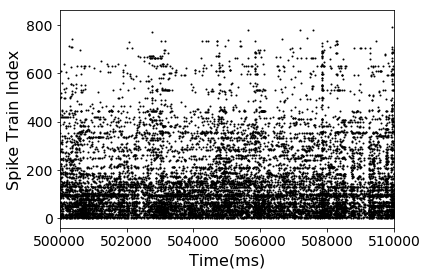

In [25]:
for i, spiketrain in enumerate(spk):
    t = spiketrain.rescale(ms)
    plt.plot(t,i*np.ones_like(t),'k.',markersize=2)
plt.axis('tight')
plt.xlim(500000,510000)
plt.xlabel('Time(ms)',fontsize=16)
plt.ylabel('Spike Train Index',fontsize=16)
plt.gca().tick_params(axis='both', which='major', labelsize=14)
plt.show()

Now let's look at mean activity across time (averaging across neurons)

In [26]:
binsize=1*s
spk_binned = conv.BinnedSpikeTrain(spk,binsize=binsize,t_start=0*s).to_array()

In [27]:
mean_spikes = np.mean(spk_binned,0)

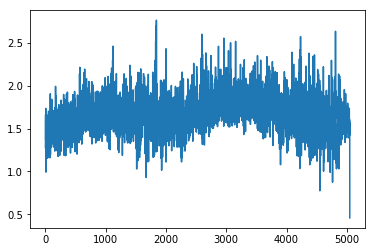

In [28]:
plt.plot(mean_spikes)

Now let's look at the histogram of number of spikes per neuron

In [29]:
total_spk = np.sum(spk_binned,-1)
total_spk.shape

(822,)

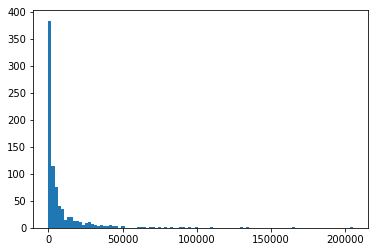

In [30]:
_=plt.hist(total_spk,bins=100)

Now let's look at the activity of a single neuron

In [31]:
neuron_ix = 200
neuron = spk_binned[neuron_ix]

In [32]:
unique,counts=np.unique(neuron,return_counts=True)

In [33]:
print unique
print counts

[0 1 2 3 5]
[3715 1101  204   29    1]


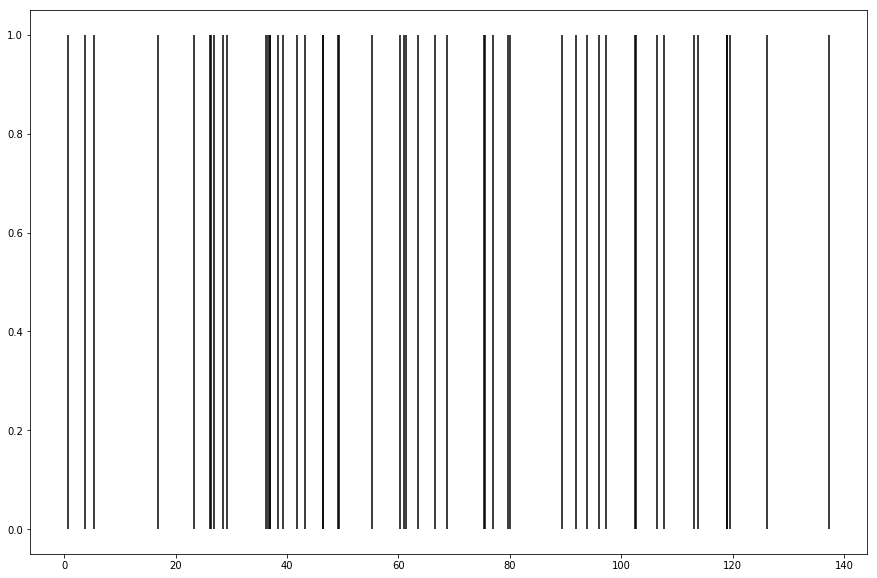

In [34]:
fig,ax=plt.subplots(figsize=(15,10))
ax.vlines(spk[neuron_ix][:50],0,1)

Let's load the experimental protocols into Python

In [57]:
# special loader function to bring nested structs into Python
import scipy.io as spio
import numpy as np


def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = scipy.io.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

In [48]:
exp1_info=loadmat('experiment1stimInfo.mat')

In [54]:
exp1_info.keys()

['Protocol',
 'stimStarts',
 '__globals__',
 '__header__',
 'stimStops',
 'stimIDs',
 '__version__']

In [56]:
exp1_info['Protocol']

{'adapt': {'flag': 0},
 'animal': u'M160102_NS2LOE',
 'iexp': 1,
 'iseries': 20160420,
 'npars': 16,
 'npfilestimuli': 13,
 'nrepeats': 10,
 'nstim': [],
 'pardefs': [u'               Stimulus duration (s *10)',
  u'                    Switch Time  (s *10)',
  u'             Temporal frequency (Hz *10)',
  u'            Spatial frequency (cpd *100)',
  u'                     Spatial phase (deg)',
  u'                       Orientation (deg)',
  u'                     Bar length (deg*10)',
  u'                 Cycles number (integer)',
  u'              Focus position, x (deg*10)',
  u'              Focus position, y (deg*10)',
  u'                 Contrast of red gun (%)',
  u'               Contrast of green gun (%)',
  u'                Contrast of blue gun (%)',
  u'           Mean luminance of red gun (%)',
  u'         Mean luminance of green gun (%)',
  u'          Mean luminance of blue gun (%)'],
 'parnames': [u'dur',
  u'swT',
  u'tf',
  u'sf',
  u'sph',
  u'ori',
  u'len',
  

In [64]:
exp1_info['stimStarts']

array([  99.10833333,  101.90833333,  104.92466667,  107.57466667,
        110.308     ,  112.958     ,  115.608     ,  118.62433333,
        121.491     ,  124.341     ,  126.99066667,  129.97433333,
        132.84066667,  135.59066667,  138.40733333,  141.174     ,
        143.757     ,  146.44033333,  149.07366667,  151.74033333,
        154.44033333,  157.22333333,  159.82333333,  162.82333333,
        165.87333333,  168.68966667,  171.48966667,  174.223     ,
        177.23966667,  179.98966667,  182.606     ,  185.57266667,
        188.33933333,  191.02266667,  193.78933333,  196.40566667,
        199.039     ,  202.089     ,  205.12233333,  207.989     ,
        210.55533333,  213.25533333,  216.00533333,  218.98866667,
        221.572     ,  224.172     ,  226.83833333,  229.73833333,
        232.67166667,  235.57166667,  238.37133333,  241.22133333,
        243.95466667,  246.87133333,  249.538     ,  252.45433333,
        255.121     ,  257.88766667,  260.771     ,  263.73766

In [65]:
exp1_info['stimIDs']

array([ 6,  3, 11,  7,  8,  5,  1,  2,  4, 13,  9, 10, 12,  9,  3,  4,  1,
        8, 12, 13,  6,  2, 10,  5, 11,  7,  6,  8,  9,  4,  7, 12,  2,  3,
       11,  5,  1, 10, 13,  1,  6, 12,  3,  2,  8,  7,  9, 13, 10, 11,  4,
        5,  3,  2,  8, 10,  6,  4, 11,  7,  1, 12,  9, 13,  5,  3,  4, 12,
        9, 13,  7,  5, 11,  2,  8,  6, 10,  1, 13,  8,  3, 11,  2,  6, 12,
        5,  1, 10,  9,  4,  7,  8,  1,  5, 10, 12,  9,  7, 13,  2,  6,  3,
       11,  4,  8, 11,  1,  9,  3,  7, 13,  2,  4,  5,  6, 12, 10,  6,  2,
       10,  4, 12, 11,  3,  7, 13,  8,  9,  5,  1], dtype=uint8)

In [66]:
exp2_info=loadmat('experiment2stimInfo.mat')

In [68]:
exp2_info.keys()

['Protocol',
 'stimStarts',
 '__globals__',
 '__header__',
 'stimStops',
 'stimIDs',
 '__version__']

In [70]:
exp2_info['stimIDs']

array([ 2,  6, 12, 10,  7,  8, 14, 13,  9, 16, 11, 15,  5,  3, 17,  4,  1,
        5, 15,  4, 16,  2,  8,  7, 14, 10, 11,  3,  6, 13, 12, 17,  1,  9,
        1, 10,  8, 11, 13, 17,  3,  7,  2,  6, 12,  9,  5, 16, 15, 14,  4,
       15,  9, 10, 11, 12, 16,  7,  6,  2, 17,  4,  1,  5, 14,  8, 13,  3,
        6, 16,  9,  8, 11,  4, 13, 10,  1,  5, 12,  3,  2, 17, 15, 14,  7,
       17, 14, 16, 13,  1,  7,  5,  2, 10,  3,  9, 12, 11,  8,  4,  6, 15,
       15,  8,  4, 12, 17,  5, 11, 13,  6, 14,  1, 16, 10,  3,  9,  2,  7,
       12,  3, 16,  6,  4, 10,  1,  2, 11, 17,  5,  9, 15,  7, 14, 13,  8,
        1, 13, 14,  7,  4,  5,  3, 15,  6,  2,  9, 16,  8, 12, 17, 10, 11,
       11,  7, 13, 12, 14,  6,  1, 10, 15, 17, 16,  5,  8,  3,  9,  2,  4], dtype=uint8)

In [71]:
exp3_info=loadmat('experiment3stimInfo.mat')

Now let's divide up the spike trains into the 4 different experimental stages, and then further into a window for each stimulus

In [76]:
len(spk)

822

In [84]:
import copy

In [85]:
e=copy.deepcopy(spk[0][:3])

In [86]:
e

<SpikeTrain(array([ 0.0054    ,  0.1295    ,  0.25956667]) * s, [0.0 s, 5050.0 s])>

In [89]:
e.t_start=10*s

In [102]:
e[(e.times<10) & (e.times>5)]

<SpikeTrain(array([], dtype=float64) * s, [10.0 s, 5050.0 s])>

In [106]:
dist_list=[]
N=exp1_info['Protocol']['npfilestimuli']*exp1_info['Protocol']['nrepeats']
exp1start=exp1_info['stimStarts']
exp1stop=exp1_info['stimStops']

In [ ]:
import elephant.spike_train_dissimilarity as dissim

for i in range(N):
    print i
    temp_spks=[]
    for spiketrain in spk:
        temp=copy.deepcopy(spiketrain[(spiketrain.times>exp1start[i])&(spiketrain.times<exp1stop[i])])
        temp_spks.append(temp)
    dist_list.append(dissim.van_rossum_dist(temp_spks,sort=False))

0
